In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
df = pd.read_csv('train3.csv',parse_dates=True,index_col='DATE')
df.columns = ['Sales']

In [3]:
df

,Sales
DATE,
1992-01-01,790
1992-02-01,539
1992-03-01,535
1992-04-01,523
1992-05-01,552
...,...
2019-06-01,672
2019-07-01,646
2019-08-01,1226


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


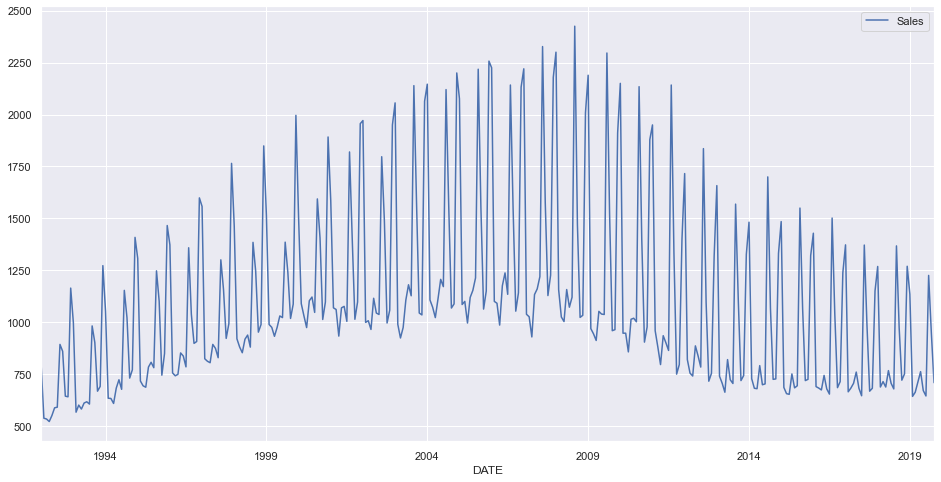

In [5]:
df.plot(figsize=(16,8)) 
plt.show() 

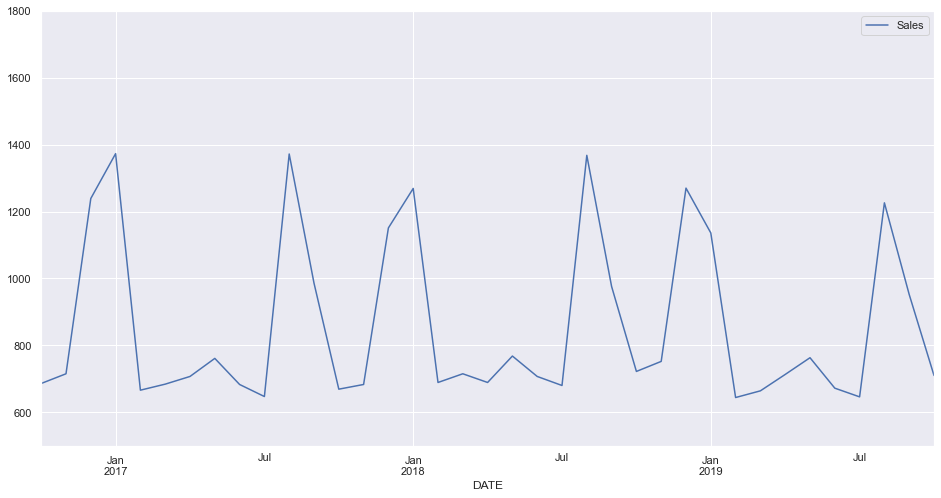

In [6]:
df.plot(figsize=(16,8))
plt.xlim('2016-10-01','2019-10-01')
plt.ylim(500,1800)
plt.show()

In [7]:
len(df) 

334

In [8]:
test_size = 18
test_ind = len(df) - test_size 

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
train

,Sales
DATE,
1992-01-01,790
1992-02-01,539
1992-03-01,535
1992-04-01,523
1992-05-01,552
...,...
2017-12-01,1151
2018-01-01,1269
2018-02-01,689


In [11]:
test

,Sales
DATE,
2018-05-01,768
2018-06-01,707
2018-07-01,680
2018-08-01,1368
2018-09-01,976
2018-10-01,722
2018-11-01,752
2018-12-01,1270
2019-01-01,1136


In [12]:
from sklearn.preprocessing import MinMaxScaler 

In [13]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# Let's redefine to go 12 months back and then predict the next month 
length = 12 
generator = TimeseriesGenerator(data=train_scaled,targets=train_scaled,
                               length=length,batch_size=1)

In [16]:
# Previewing the first batch
X,y = generator[0]

In [17]:
print(f'Given the Array: \n{X}') 
print(f'Next Predicted Value: \n {y}') 

Given the Array: 
[[[0.14037855]
  [0.0084122 ]
  [0.00630915]
  [0.        ]
  [0.01524711]
  [0.03470032]
  [0.0362776 ]
  [0.19505783]
  [0.17770768]
  [0.06414301]
  [0.06256572]
  [0.33753943]]]
Next Predicted Value: 
 [[0.24973712]]


# creating a model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import EarlyStopping 

In [19]:
n_features = 1

In [20]:
model = Sequential()
model.add(LSTM(units=100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [23]:
validation_genenerator = TimeseriesGenerator(data=test_scaled,targets=test_scaled,
                                            length=length,batch_size=1)

In [24]:
# Fitting model
model.fit_generator(generator,epochs=20,validation_data=validation_genenerator,callbacks=[early_stop])

Epoch 1/20


C:\Users\krishna\AppData\Local\Temp/ipykernel_17388/188521164.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,validation_data=validation_genenerator,callbacks=[early_stop])


304/304 [==============================] - 8s 15ms/step - loss: 0.0493 - val_loss: 0.0146
Epoch 2/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0362 - val_loss: 0.0071
Epoch 3/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0093 - val_loss: 0.0015
Epoch 4/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 5/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0042 - val_loss: 8.7656e-04
Epoch 6/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0039 - val_loss: 4.1326e-04
Epoch 7/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0039 - val_loss: 8.6237e-04
Epoch 8/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0038 - val_loss: 3.8208e-04
Epoch 9/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0032 - v

In [25]:
losses = pd.DataFrame(model.history.history)
losses.index = losses.index + 1

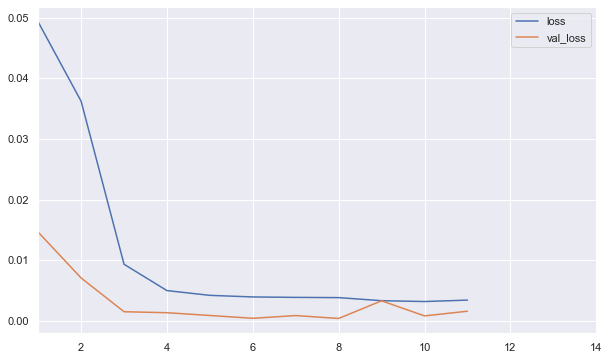

In [26]:
losses.plot(figsize=(10,6))
plt.xlim(1,14)
plt.show()

In [27]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 62ms/step


In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [30]:
test['Predictions'] = true_predictions

C:\Users\krishna\AppData\Local\Temp/ipykernel_17388/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [31]:
test

,Sales,Predictions
DATE,,
2018-05-01,768,795.679768
2018-06-01,707,737.134857
2018-07-01,680,723.023201
2018-08-01,1368,1342.402669
2018-09-01,976,1033.425857
2018-10-01,722,748.962133
2018-11-01,752,754.475830
2018-12-01,1270,1167.813459
2019-01-01,1136,1288.450822


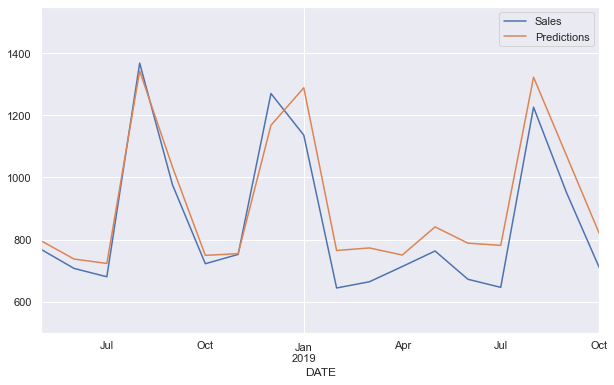

In [32]:
test.plot(figsize=(10,6))
plt.ylim(500,1550)
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Sales'],test['Predictions']))

89.15542983835142

# Forecasting into the end of 2020

In [34]:
# All data will now be used to train a new model.
full_scaler = MinMaxScaler()
full_data_scaled = full_scaler.fit_transform(df)

In [36]:
length = 12
generator_full_data = TimeseriesGenerator(full_data_scaled,full_data_scaled,
                               length=length,batch_size=1)

In [37]:
model = Sequential()
model.add(LSTM(units=100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

# 11 epochs was selected since the previous model above yielded the lowest loss after 11 epochs.
model.fit_generator(generator_full_data,epochs=11)

Epoch 1/11


C:\Users\krishna\AppData\Local\Temp/ipykernel_17388/2837785906.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator_full_data,epochs=11)


322/322 [==============================] - 7s 11ms/step - loss: 0.0485
Epoch 2/11
322/322 [==============================] - 4s 11ms/step - loss: 0.0376
Epoch 3/11
322/322 [==============================] - 4s 12ms/step - loss: 0.0232
Epoch 4/11
322/322 [==============================] - 4s 13ms/step - loss: 0.0145
Epoch 5/11
322/322 [==============================] - 4s 13ms/step - loss: 0.0066
Epoch 6/11
322/322 [==============================] - 4s 11ms/step - loss: 0.0043
Epoch 7/11
322/322 [==============================] - 4s 11ms/step - loss: 0.0031
Epoch 8/11
322/322 [==============================] - 4s 12ms/step - loss: 0.0036
Epoch 9/11
322/322 [==============================] - 4s 11ms/step - loss: 0.0043
Epoch 10/11
322/322 [==============================] - 4s 11ms/step - loss: 0.0035
Epoch 11/11
322/322 [==============================] - 4s 11ms/step - loss: 0.0030


In [44]:
forecast = []
# We will forecast into the next 14 months to give us sales predictions through the end of 2020.
periods = 14

first_eval_batch = full_data_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 59ms/step


In [45]:
forecast = scaler.inverse_transform(forecast)

In [46]:
forecast

array([[ 877.01438925],
       [1430.34174323],
       [1329.34352183],
       [ 794.02989504],
       [ 793.9213168 ],
       [ 830.73444   ],
       [ 875.80401543],
       [ 785.71162888],
       [ 761.36346278],
       [1367.34732115],
       [1095.90711886],
       [ 830.80084532],
       [1003.72258192],
       [1585.27390003]])

In [47]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,
                              freq='MS')

In [48]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                          columns=['Forecast'])

In [49]:
forecast_df

,Forecast
2019-11-01,877.014389
2019-12-01,1430.341743
2020-01-01,1329.343522
2020-02-01,794.029895
2020-03-01,793.921317
2020-04-01,830.734440
2020-05-01,875.804015
2020-06-01,785.711629
2020-07-01,761.363463
2020-08-01,1367.347321


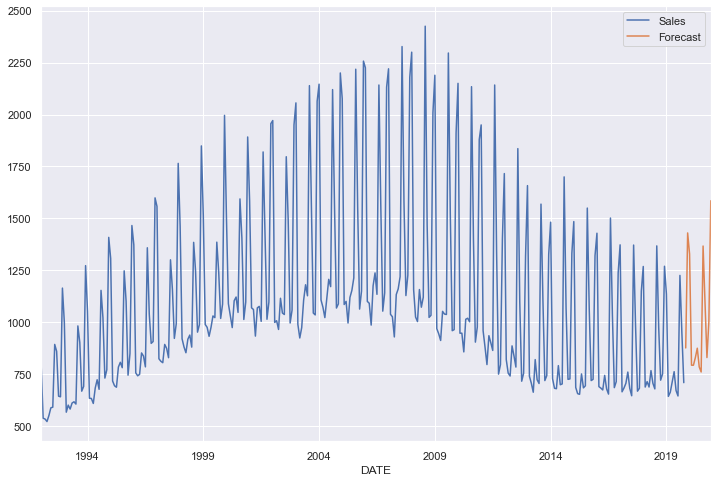

In [50]:
ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)
plt.show()

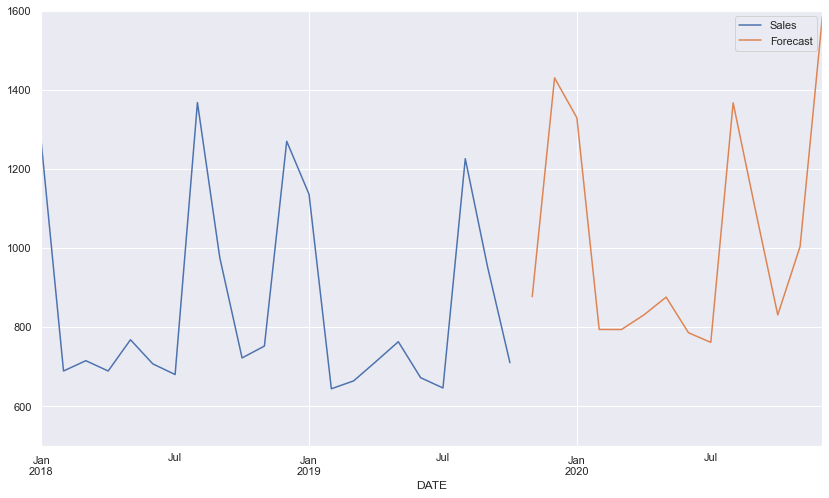

In [51]:
ax = df.plot(figsize=(14,8))
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')
plt.ylim(500,1600)
plt.show()